In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    Dense,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
    Reshape,
)

from kapre.composed import get_stft_magnitude_layer
import datetime

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")

Tensorflow datasets: 4.2.0
Tensorflow: 2.4.1
Numpy: 1.19.5
Matplotlib: 3.4.1


In [3]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["test[:70%]", "test[70%:90%]", "test[90%:]"],
    data_dir=data_dir,
    with_info=True,
)

In [4]:
tfds.as_dataframe(train.take(3), info)

audio audio/id audio/machine  \
0  [-257, -574, -314, -386, -539, -129, -196, -41...  b'0020'         b'02'   
1  [-451, 61, 754, -77, 765, 579, 912, 203, 10, 5...  b'0131'         b'00'   
2  [275, 286, 318, 279, 271, 302, 220, -16, -150,...  b'0023'         b'02'   

   audio/split  label  
0            1      1  
1            1      1  
2            1      1

In [5]:
train_df = tfds.as_dataframe(train, info)
train_df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[-257, -574, -314, -386, -539, -129, -196, -41...",b'0020',b'02',1,1
1,"[-451, 61, 754, -77, 765, 579, 912, 203, 10, 5...",b'0131',b'00',1,1
2,"[275, 286, 318, 279, 271, 302, 220, -16, -150,...",b'0023',b'02',1,1
3,"[125, 274, 226, 38, 42, -101, 40, 89, 199, 165...",b'0022',b'06',1,0
4,"[-160, -566, -395, -693, -724, -254, -44, 186,...",b'0053',b'04',1,1


In [6]:
(
    train_df
    .pivot_table(
        values="audio/id",
        index=["audio/machine"],
        columns=["label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
)

label,0,1
audio/machine,,
b'00',74,96
b'02',62,83
b'04',74,70
b'06',72,68


In [7]:
tfds.as_dataframe(val.take(3), info)

audio audio/id audio/machine  \
0  [347, 109, 519, 743, 623, 282, 353, -120, 19, ...  b'0069'         b'04'   
1  [165, 165, -87, -580, -685, -633, -795, -927, ...  b'0096'         b'00'   
2  [-398, -646, -320, -167, -403, -599, -587, -27...  b'0020'         b'00'   

   audio/split  label  
0            1      0  
1            1      1  
2            1      1

In [8]:
val_df = tfds.as_dataframe(val, info)
val_df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[347, 109, 519, 743, 623, 282, 353, -120, 19, ...",b'0069',b'04',1,0
1,"[165, 165, -87, -580, -685, -633, -795, -927, ...",b'0096',b'00',1,1
2,"[-398, -646, -320, -167, -403, -599, -587, -27...",b'0020',b'00',1,1
3,"[-630, -659, -773, -560, -325, -321, -281, -28...",b'0119',b'00',1,1
4,"[121, 18, -89, 2, 364, 330, 177, -51, 167, 253...",b'0026',b'04',1,0


In [9]:
(
    val_df
    .pivot_table(
        values="audio/id",
        index=["audio/machine"],
        columns=["label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
)

label,0,1
audio/machine,,
b'00',20,30
b'02',22,20
b'04',16,18
b'06',20,25


In [10]:
tfds.as_dataframe(test.take(3), info)

audio audio/id audio/machine  \
0  [-211, -351, -405, -402, -281, -62, -97, -290,...  b'0028'         b'02'   
1  [-95, 321, -35, -476, -336, -671, -427, -932, ...  b'0008'         b'02'   
2  [263, 190, 82, 69, -9, -197, 39, 21, -180, -50...  b'0081'         b'04'   

   audio/split  label  
0            1      1  
1            1      1  
2            1      1

In [11]:
test_df = tfds.as_dataframe(test, info)
test_df.head()

,audio,audio/id,audio/machine,audio/split,label
0,"[-211, -351, -405, -402, -281, -62, -97, -290,...",b'0028',b'02',1,1
1,"[-95, 321, -35, -476, -336, -671, -427, -932, ...",b'0008',b'02',1,1
2,"[263, 190, 82, 69, -9, -197, 39, 21, -180, -50...",b'0081',b'04',1,1
3,"[-407, -195, -28, -107, -352, -334, -318, -641...",b'0006',b'04',1,1
4,"[76, 17, 115, 542, 515, 228, 55, 131, 291, 429...",b'0058',b'00',1,1


In [12]:
(
    test_df
    .pivot_table(
        values="audio/id",
        index=["audio/machine"],
        columns=["label"],
        aggfunc='count',
        fill_value=0,
        observed=True)
)

label,0,1
audio/machine,,
b'00',6,17
b'02',16,8
b'04',10,12
b'06',8,9


In [13]:
def get_info(item):
    return item["audio"], item["label"]

In [14]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 128

train = train.map(get_info).batch(BATCH_SIZE)
val = val.map(get_info).batch(BATCH_SIZE)
test = test.map(get_info).batch(BATCH_SIZE)

In [15]:
model = tf.keras.Sequential(
    [
        Reshape((160_000,1), input_shape=(160_000,)),
        get_stft_magnitude_layer(
            input_shape=(info.features['audio'].shape[0], 1), n_fft=1024, win_length=1024, hop_length=512
        ),
        BatchNormalization(),
        Conv2D(filters=8, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(3, 3)),
        BatchNormalization(),
        Conv2D(filters=16, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 3)),
        BatchNormalization(),
        Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 3)),
        BatchNormalization(),
        Flatten(),
        Dense(units=64, activation="relu"),
        Dropout(0.1),
        Dense(units=8, activation="relu"),
        Dropout(0.1),
        Dense(units=1, activation="sigmoid"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 160000, 1)         0         
_________________________________________________________________
stft_magnitude (Sequential)  (None, 311, 513, 1)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 311, 513, 1)       4         
_________________________________________________________________
conv2d (Conv2D)              (None, 311, 513, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 103, 171, 8)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 103, 171, 8)       32        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 103, 171, 16)      1

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
log_dir = os.path.join("../logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [18]:
history = model.fit(
    train,
    epochs=20,
    shuffle=True,
    validation_data=val,
    callbacks=[tb_callback],
    verbose=1,
)

Epoch 1/20
19/19 [==============================] - 18s 924ms/step - loss: 0.8285 - accuracy: 0.4946 - val_loss: 1.0136 - val_accuracy: 0.5380
Epoch 2/20
19/19 [==============================] - 18s 938ms/step - loss: 0.6472 - accuracy: 0.5255 - val_loss: 1.0402 - val_accuracy: 0.5439
Epoch 3/20
19/19 [==============================] - 18s 931ms/step - loss: 0.5916 - accuracy: 0.6464 - val_loss: 1.0771 - val_accuracy: 0.5439
Epoch 4/20
19/19 [==============================] - 18s 922ms/step - loss: 0.5737 - accuracy: 0.6592 - val_loss: 0.7888 - val_accuracy: 0.5380
Epoch 5/20
19/19 [==============================] - 18s 929ms/step - loss: 0.5497 - accuracy: 0.7117 - val_loss: 0.5345 - val_accuracy: 0.6959
Epoch 6/20
19/19 [==============================] - 18s 941ms/step - loss: 0.5389 - accuracy: 0.7160 - val_loss: 0.5343 - val_accuracy: 0.6959
Epoch 7/20
19/19 [==============================] - 18s 933ms/step - loss: 0.5130 - accuracy: 0.7504 - val_loss: 0.5590 - val_accuracy: 0.7018

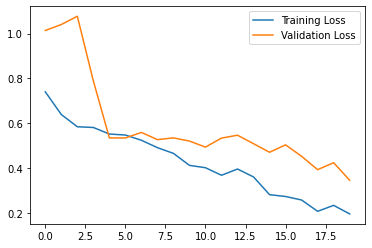

In [19]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

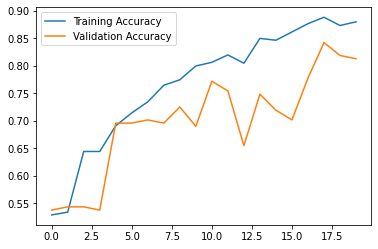

In [20]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

In [21]:
test_loss, test_acc = model.evaluate(test)
print(f"\nTest accuracy: {test_acc}")

3/3 [==============================] - 1s 168ms/step - loss: 0.5920 - accuracy: 0.7558

Test accuracy: 0.7558139562606812


In [22]:
VERSION="1"
saved_model_path = model.save(os.path.join("..", "models", "stft", VERSION), save_format='tf')

INFO:tensorflow:Assets written to: ..\models\stft\1\assets


INFO:tensorflow:Assets written to: ..\models\stft\1\assets


In [23]:
!saved_model_cli show --dir ../models/stft/1 --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['reshape_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 160000)
        name: serving_default_reshape_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_2'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Defined Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          reshape_in

2021-04-30 10:18:58.838277: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-04-30 10:18:58.838472: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
